<a href="https://colab.research.google.com/github/enriquecorimayo/Doctorado/blob/main/QLBSwithSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install QuantLib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.8 MB 118 kB/s 


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import QuantLib as ql
import sys

sys.path.append("..")

import time
import matplotlib.pyplot as plt

## Parameters for MC simulation of stock prices

In [84]:
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
M = 1         # maturity
T = 252        # number of time steps

N_MC = 10000 # 10000 # 50000   # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

### Black-Sholes Simulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Sholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

where $Z$ is a standard normal random variable.

Based on simulated stock price $S_t$ paths, compute state variable $X_t$ by the following relation.

$$X_t=-\left(\mu-\frac{1}{2}\sigma^2\right)t\Delta t+\log S_t$$

Also compute

$$\Delta S_t=S_{t+1}-e^{r\Delta t}S_t\quad\quad \Delta\hat{S}_t=\Delta S_t-\Delta\bar{S}_t\quad\quad t=0,...,T-1$$

where $\Delta\bar{S}_t$ is the sample mean of all values of $\Delta S_t$.

Plots of 5 stock price $S_t$ and state variable $X_t$ paths are shown below.


Time Cost: 3.2613003253936768 seconds


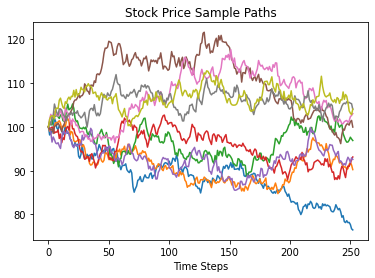

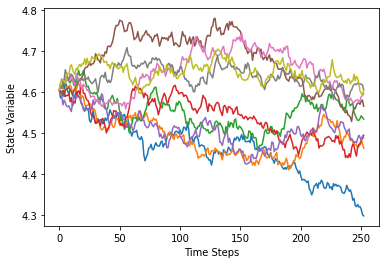

In [29]:
# make a dataset 

starttime = time.time()
np.random.seed(42) # Fix random seed
# stock price
S_BS = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S_BS.loc[:,0] = S0

# standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S_BS.loc[:,t] = S_BS.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S = S_BS.loc[:,1:T].values - np.exp(r * delta_t) * S_BS.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# state variable
X_BS = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S_BS)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S_BS.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X_BS.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

### Merton76 (Jump Diffusion) Simulation


In [33]:
# stock price
S_M76 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S_M76.loc[:,0] = S0



Time Cost: 1736.939020872116 seconds


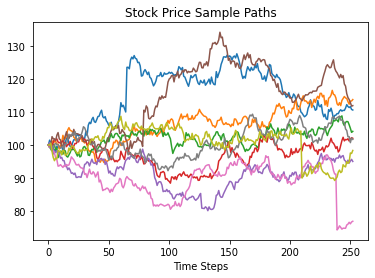

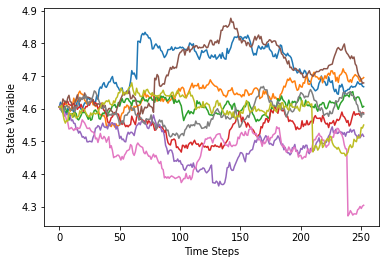

In [81]:
def merton_jump_paths(S, T, r, sigma,  lam, m, v, steps, Npaths):
    size=(steps,Npaths+1)
    dt = T/steps 
    poi_rv = np.multiply(np.random.poisson( lam*dt, size=size),
                         np.random.normal(m,v, size=size)).cumsum(axis=0)
    geo = np.cumsum(((r -  sigma**2/2 -lam*(m  + v**2*0.5))*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=size)), axis=0)
    
    return np.exp(geo+poi_rv)*S
m = -0.1 # meean of jump size
v = 0.3 # standard deviation of jump
lam =1 # intensity of jump i.e. number of jumps per annum

jumpDiffusionPaths = merton_jump_paths(S0, M, r, sigma, lam, m, v, T, N_MC-1)
S_M76.loc[:,1:] = np.transpose(jumpDiffusionPaths)

# state variable
X_M76 = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S_M76)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S_M76.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X_M76.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

###Heston Model Simulation

In [90]:
def generate_multi_paths_df(seq, num_paths, steps):
    spot_paths = []
    vol_paths = []

    for i in range(num_paths):
        sample_path = seq.next()
        values = sample_path.value()

        spot, vol = values

        spot_paths.append([x for x in spot])
        vol_paths.append([x for x in vol])

    df_spot = pd.DataFrame(spot_paths, columns=range(steps+1))
    df_vol = pd.DataFrame(vol_paths, columns=range(steps+1))

    return df_spot, df_vol

In [85]:
today = ql.Date().todaysDate()
riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.00, ql.Actual365Fixed()))

initialValue = ql.QuoteHandle(ql.SimpleQuote(S0))

v0 = 0.005
kappa = 0.8
theta = 0.008
rho = 0.2

hestonProcess = ql.HestonProcess(riskFreeTS, dividendTS, initialValue, v0, kappa, theta, sigma, rho)

In [91]:
times = ql.TimeGrid(M, T)

dimension = hestonProcess.factors()

rng = ql.GaussianRandomSequenceGenerator(
    ql.UniformRandomSequenceGenerator(dimension * T, ql.UniformRandomGenerator())
)
seq = ql.GaussianMultiPathGenerator(hestonProcess, list(times), rng, False)

df_spot,df_vol = generate_multi_paths_df(seq, N_MC,T)


Time Cost: 2672.0899069309235 seconds


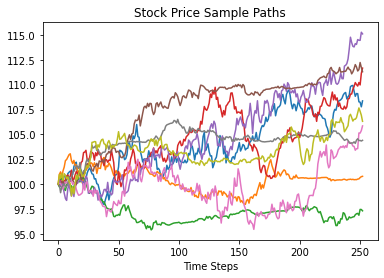

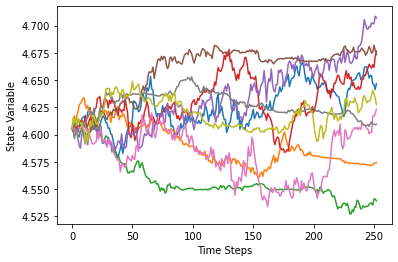

In [93]:
# Heston df
S_Heston = df_spot
# state variable
X_Heston = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S_Heston)   # delta_t here is due to their conventions

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

# plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S_Heston.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X_Heston.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()